In [ ]:
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import time

sns.set_context('paper', font_scale=2.0, rc={'lines.linewidth': 2.0})
sns.set_style('whitegrid')

# We use INTEGRATION_LIMIT instead of infinity in integration limits
INTEGRATION_LIMIT = 10.
# Threshold for testing the unbiasedness of estimators
EPS = 1e-4

In [3]:
class SquareCost(object):
  """The cost f(x; k) = (x - k)^2"""
  name = 'square'

  def __init__(self, k):
    self.k = k

  def value(self, x):
    return (x - self.k) ** 2

  def derivative(self, x):
    return 2 * (x - self.k)


class CosineCost(object):
  """The cost f(x; k) = cos kx"""
  name = 'cos'

  def __init__(self, k):
    self.k = k

  def value(self, x):
    return np.cos(self.k * x)

  def derivative(self, x):
    return -self.k * np.sin(self.k * x)


class ExponentialCost(object):
  """The cost f(x; k) = exp(-k x^2)"""
  name = 'exp'

  def __init__(self, k):
    self.k = k

  def value(self, x):
    return np.exp(-self.k * x ** 2)

  def derivative(self, x):
    return (-2 * self.k * x) * np.exp(-self.k * x ** 2)

In [4]:
class Normal(object):
  """Univariate Normal (Gaussian) measure."""
  def __init__(self, mean, std, verify_unbiasedness):
    self.distrib = scipy.stats.norm(loc=mean, scale=std)
    self.mean = mean
    self.std = std
    self.verify_unbiasedness = verify_unbiasedness

  def expect(self, g):
    """Computes the mean: E_p(x) g(x)"""
    return scipy.integrate.quad(lambda x: self.distrib.pdf(x) * g(x),
                                -INTEGRATION_LIMIT, INTEGRATION_LIMIT)

  def var(self, g, expect_g):
    """Compute the variance given the mean: E_p(x) (g(x) - E g(x))^2"""
    if self.verify_unbiasedness:
      assert (self.expect(g)[0] - expect_g) ** 2 < EPS
    return self.expect(lambda x: (g(x) - expect_g) ** 2)

  def cov(self, g, expect_g, h, expect_h):
    """Computes the covariance of two functions given their means:
    
    E_p(x) (f(x) - E f(x)) (g(x) - E g(x))
    """
    if self.verify_unbiasedness:
      assert (self.expect(g)[0] - expect_g) ** 2 < EPS
      assert (self.expect(h)[0] - expect_h) ** 2 < EPS
    return self.expect(lambda x: (g(x) - expect_g) * (h(x) - expect_h))

  def dlogpdf_dmean(self, x):
    """Computes the score function for mean: \nabla_mean \log p(x; mean, std)
    
    The score function is part of the score function estimator, see eqn. (13)
    """
    return (x - self.mean) / self.std ** 2

  def dlogpdf_dstd(self, x):
    """Computes the score function for the std: \nabla_std \log p(x; mean, std)
    
    The score function is part of the score function estimator, see eqn. (13)
    """
    return -(((self.mean + self.std - x) *
              (-self.mean + self.std + x)) / self.std ** 3)

  def dx_dmean(self, x):
    """Computes \nabla_mean x.
    
    This is part of the pathwise estimator, see eqn. (35b).
    For derivation, see eqn. (37).
    """
    return 1.

  def dx_dstd(self, x):
    """Computes \nabla_std x.
    
    This is part of the pathwise estimator, see eqn. (35b).
    For derivation, see eqn. (37).
    """
    return (x - self.mean) / self.std


class StandardWeibull(object):
  """Weibull(2, 0.5) is a distribution used for measure-valued derivative w.r.t.
  Normal mean.
  
  See equation (46) for the derivation. This distribution has a density
  function x * exp(-x^2 / 2) for x > 0
  """
  def __init__(self, verify_unbiasedness):
    self.verify_unbiasedness = verify_unbiasedness

  def expect(self, g):
    """Computes the mean: E_Weibull(x) g(x)"""
    weibull_pdf = lambda x: x * np.exp(-0.5 * x ** 2)

    return scipy.integrate.quad(lambda x: weibull_pdf(x) * g(x),
                                0, INTEGRATION_LIMIT)

  def var(self, g, expect_g):
    """Compute the variance given the mean: E_Weibull(x) (g(x) - E g(x))^2"""
    if self.verify_unbiasedness:
      assert (self.expect(g)[0] - expect_g) ** 2 < EPS
    return self.expect(lambda x: (g(x) - expect_g) ** 2)


class StandardDsMaxwellCoupledWithNormal(object):
  """This is standard double-sided Maxwell distribution coupled with
  standard Normal distribution. This is a bivariate distribution which is used
  for measure-valued derivative w.r.t. Normal standard deviation, see Table 1.
  
  Standard double-sided Maxwell distribution has the density function
  x^2 exp(-x^2 / 2) / sqrt(2 pi) for x \in R.
  
  To reduce the variance of the estimator, we couple the positve
  (double-sided Maxwell) and negative (Gaussian) parts of the estimator.
  See Section 7.2 for discussion of this idea. Technically, this is achieved
  by representing a standard Normal sample as (m*u),
  where m ~ DSMaxwell and u ~ U[0, 1].
  """
  def __init__(self, verify_unbiasedness):
    self.verify_unbiasedness = verify_unbiasedness

  def expect(self, g):
    """Computes the mean E_p(m, n) g(m, n) where m has a marginal DS-Maxwell
    distribution and n has a marginal Normal distribution."""
    def ds_maxwell_pdf(x):
      return x ** 2 * np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)

    return scipy.integrate.dblquad(
        # m: Double Sided Maxwell, u: U[0, 1]
        # The PDF of U[0, 1] is constant 1.
        lambda m, u: ds_maxwell_pdf(m) * g(m, m * u),
        # Limits for Uniform
        0, 1,
        # Limits for Double Sided Maxwell. Infinity is not supported by dblquad.
        lambda x: -INTEGRATION_LIMIT, lambda x: INTEGRATION_LIMIT,
    )

  def var(self, g, expect_g):
    """Computes the variance E_p(m, n) (g(m, n) - E g(m, n)), where m has
    a marginal DS-Maxwell distribution and n has a marginal Normal
    distribution."""
    if self.verify_unbiasedness:
      assert (self.expect(g)[0] - expect_g) ** 2 < EPS
    return self.expect(lambda m, n: (g(m, n) - expect_g) ** 2)

In [38]:
def numerical_integration(Cost, k, mean, std, verify_unbiasedness=False):
  """This function numerically evaluates the variance of gradient estimators.

  Arguments:
    Cost: the class of a cost function
    k: a list/NumPy vector of values for the cost parameter k
    mean: a scalar parameter of the Normal measure
    std: a scalar parameter of the Normal measure
    verify_unbiasedness: if True, perform additional asserts that verify
      that the estimators are unbiased
  Returns:
    A dictionary {key: NumPy array}. The keys have the form var_..., where ...
      is the name of the estimator. The dimensions of the NumPy arrays are
      [len(k), 2, 2], where the second dimension is [dmean, dstd], and the last
      dimension is [value, integration_error].
  """

  measure = Normal(mean, std, verify_unbiasedness)
  weibull = StandardWeibull(verify_unbiasedness)
  ds_maxwell_coupled_with_normal = StandardDsMaxwellCoupledWithNormal(
      verify_unbiasedness)
  
  ret = {}
  timing = {}
  for key in ['var_sf',
              'var_pathwise',
              'var_measure_valued_coupled']:
    ret[key] = np.zeros([len(k), 2, 2])
    timing[key] = 0

  for i in range(len(k)):
    cost = Cost(k[i])

    # Compute $\nabla_{\theta} \int \mathcal{N}(x|\mu, \sigma^2) f(x; k) dx$
    # using the score-function estimator
    d_expect_loss = [
        measure.expect(lambda x: cost.value(x) * measure.dlogpdf_dmean(x))[0],
        measure.expect(lambda x: cost.value(x) * measure.dlogpdf_dstd(x))[0]
        ]

    # Variance of the score-function estimator: Section 4, eqn. (13)
    start_time1 = time.time()
    ret['var_sf'][i] = [
        measure.var(lambda x: cost.value(x) * measure.dlogpdf_dmean(x),
                    d_expect_loss[0]),
        measure.var(lambda x: cost.value(x) * measure.dlogpdf_dstd(x),
                    d_expect_loss[1])
        ]
    timing['var_sf'] += time.time() - start_time1
    # Variance of the pathwise estimator. Here we use the "implicit" form of the
    # estimator that allows reusing the same Gaussian measure.
    # See Section 5, eqn. (35) for details
    start_time4 = time.time()
    ret['var_pathwise'][i] = [
        measure.var(lambda x: cost.derivative(x) * measure.dx_dmean(x),
                    d_expect_loss[0]),
        measure.var(lambda x: cost.derivative(x) * measure.dx_dstd(x),
                    d_expect_loss[1])
        ]
    timing['var_pathwise'] += time.time() - start_time4

    # Variance of the measure-valued gradient estimator (Section 6, eqn. (44),
    # Table 1) with variance reduction via coupling (Section 7.2)
    start_time5 = time.time()
    ret['var_measure_valued_coupled'][i] = [
        # We couple the Weibulls from the positive and negative parts of the
        # estimator simply by reusing the value of the Weibull
        weibull.var(
            lambda x: (cost.value(mean + std * x) - cost.value(mean - std * x)) / (np.sqrt(2 * np.pi) * std), d_expect_loss[0]),
        # See Section 7.2 and documentation of StandardDsMaxwellCoupledWithNormal
        # for details on this coupling. Here m ~ DS-Maxwell, n ~ Normal(0, 1)
        ds_maxwell_coupled_with_normal.var(
            lambda m, n: (cost.value(m * std + mean) - cost.value(n * std + mean)) / std, d_expect_loss[1])
        ]
    timing['var_measure_valued_coupled'] += time.time() - start_time5

  return ret, timing

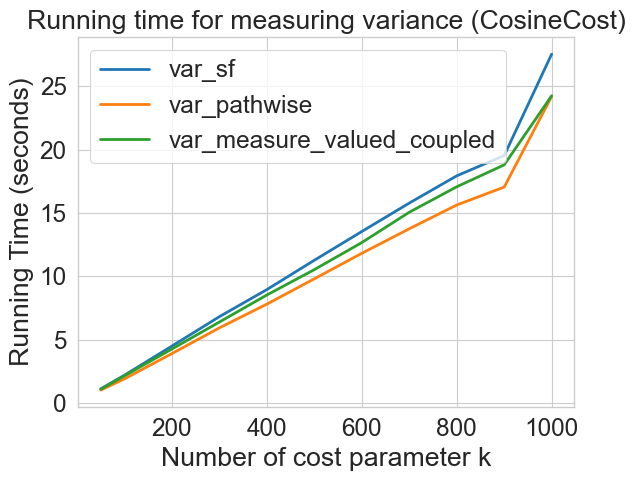

In [43]:
Cost = CosineCost
k_sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
timings = {
    'var_sf': [],
    'var_pathwise': [],
    'var_measure_valued_coupled': []
}

for size in k_sizes:
    k_values = np.linspace(-3, 3, size)
    _, timing = numerical_integration(Cost, k_values, mean=1, std=1, verify_unbiasedness=False)
    for key in timings:
        timings[key].append(timing[key])

plt.figure()
for key in timings:
    plt.plot(k_sizes, timings[key], label=key)

plt.xlabel('Number of cost parameter k')
plt.ylabel('Running Time (seconds)')
plt.title('Running time for measuring variance (CosineCost)')
plt.legend()
plt.grid(True)
plt.show()

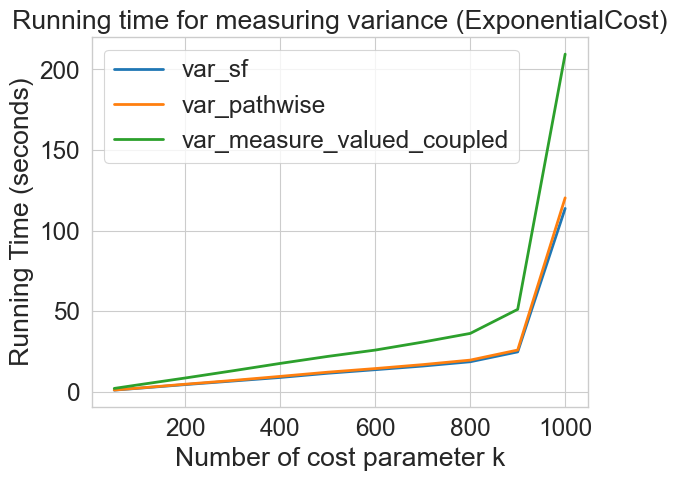

In [49]:
Cost = ExponentialCost
k_sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
timings = {
    'var_sf': [],
    'var_pathwise': [],
    'var_measure_valued_coupled': []
}

for size in k_sizes:
    k_values = np.linspace(1e-10, 6, size)
    _, timing = numerical_integration(Cost, k_values, mean=1, std=1, verify_unbiasedness=False)
    for key in timings:
        timings[key].append(timing[key])

plt.figure()
for key in timings:
    plt.plot(k_sizes, timings[key], label=key)

plt.xlabel('Number of cost parameter k')
plt.ylabel('Running Time (seconds)')
plt.title('Running time for measuring variance (ExponentialCost)')
plt.legend()
plt.grid(True)
plt.show()

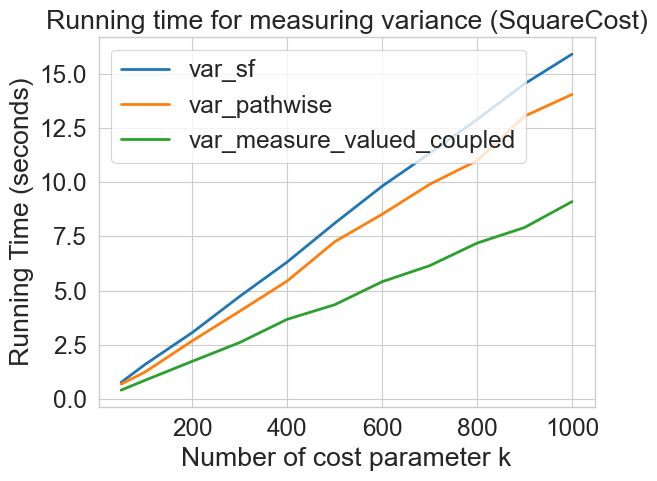

In [52]:
Cost = SquareCost
k_sizes = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
timings = {
    'var_sf': [],
    'var_pathwise': [],
    'var_measure_valued_coupled': []
}

for size in k_sizes:
    k_values = np.linspace(1e-10, 6, size)
    _, timing = numerical_integration(Cost, k_values, mean=1, std=1, verify_unbiasedness=False)
    for key in timings:
        timings[key].append(timing[key])

plt.figure()
for key in timings:
    plt.plot(k_sizes, timings[key], label=key)

plt.xlabel('Number of cost parameter k')
plt.ylabel('Running Time (seconds)')
plt.title('Running time for measuring variance (SquareCost)')
plt.legend()
plt.grid(True)
plt.show()